In [1]:
# https://developers.google.com/optimization/introduction/python

In [2]:
%reset -sf
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

# Define problem

In [3]:
# Define four parallel arrays: start_nodes, end_nodes, capacities, and unit costs
# between each pair. For instance, the arc from node 0 to node 1 has a
# capacity of 15 and a unit cost of 4.

edges = pd.DataFrame()
edges["start_nodes"] = [ 0, 0,  1, 1,  1,  2, 2,  3, 4, 0]
edges["end_nodes"]   = [ 1, 2,  2, 3,  4,  3, 4,  4, 2, 5]
edges["unit_costs"]  = [ 4, 4,  2, 2,  6,  1, 3,  2, 3, 1]
edges["capacities"]  = [15, 8, 20, 4, 10, 15, 4, 20, 5, 9] # disabled
edges["flows"]       = [ 0, 0,  0, 0,  0,  0, 0,  0, 0, 0]
edges["names"]       = "x"+edges[["start_nodes",
                                  "end_nodes"]].astype(str).apply(''.join, axis=1)
edges.index = edges["names"]

nodes = pd.DataFrame()
supplies = [20, 2, 3, 5, 15, 5]
N = len(supplies) # the number of nodes at init
nodes["supplies"] = supplies
nodes["x"] = [1,2,0,3,1,2]
nodes["y"] = [0,0,1,1,2,2]

# Augment nodes to a common sink

In [4]:
def augment_nodes(nodes, edges):
    for i,ss in enumerate(nodes["supplies"]):
        edges.loc[len(edges)] = [i, len(nodes), 1, 999, 0,
                                 "x"+str(i)+str(len(nodes))]
    nodes.loc[len(edges)] = [-sum(nodes["supplies"]), -1, -1]
    edges.index = edges["names"]
    return nodes, edges

In [5]:
nodes, edges = augment_nodes(nodes, edges)
# nodes
# edges

# Making graph undirected

In [6]:
def make_undirected(edges):
    for i,row in edges.iterrows():
        row["end_nodes"], row["start_nodes"] = row["start_nodes"], row["end_nodes"]
        row["names"] = "x"+str(row["start_nodes"])+str(row["end_nodes"])
        edges.loc[len(edges)] = row
    edges.index = edges["names"]
    return edges

In [7]:
edges = make_undirected(edges)
edges

,start_nodes,end_nodes,unit_costs,capacities,flows,names
names,,,,,,
x01,0,1,4,15,0,x01
x02,0,2,4,8,0,x02
x12,1,2,2,20,0,x12
x13,1,3,2,4,0,x13
x14,1,4,6,10,0,x14
x23,2,3,1,15,0,x23
x24,2,4,3,4,0,x24
x34,3,4,2,20,0,x34
x42,4,2,3,5,0,x42


# Generate adjacency matrix

In [8]:
def get_adjacency_matrix(edges):
    start_nodes = edges["start_nodes"]
    end_nodes = edges["end_nodes"]
    unit_costs = edges["unit_costs"]
    capacities = edges["capacities"]
    flows = edges["flows"]
    names = edges["names"]
    
    matrix_unit_costs = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_capacities = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_flows      = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_names      = [["x"+str(i)+str(j)
                          for i in range(N+1)] 
                         for j in range(N+1)]
    
    for x,y,z,c,f,n in zip(start_nodes, end_nodes, unit_costs, capacities, flows, names):
        matrix_unit_costs[x][y] = z
        matrix_capacities[x][y] = c
        matrix_flows     [x][y] = f
        
    for y,x,z,c,f,n in zip(start_nodes, end_nodes, unit_costs, capacities, flows, names):
        matrix_unit_costs[x][y] = z
        matrix_capacities[x][y] = c
        matrix_flows     [x][y] = f

    return matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names

matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names = get_adjacency_matrix(edges)

In [9]:
# matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names

# Visualisation

In [10]:
edges

,start_nodes,end_nodes,unit_costs,capacities,flows,names
names,,,,,,
x01,0,1,4,15,0,x01
x02,0,2,4,8,0,x02
x12,1,2,2,20,0,x12
x13,1,3,2,4,0,x13
x14,1,4,6,10,0,x14
x23,2,3,1,15,0,x23
x24,2,4,3,4,0,x24
x34,3,4,2,20,0,x34
x42,4,2,3,5,0,x42


In [11]:
def plot_graph(nodes, edges):
    start_nodes = edges["start_nodes"]
    end_nodes = edges["end_nodes"]
    unit_costs = edges["unit_costs"]
    capacities = edges["capacities"]
    flows = edges["flows"]
    names = edges["names"]

    G = nx.DiGraph()
    for x,y,z,c,f,n in zip(start_nodes, end_nodes, unit_costs, capacities, flows, names):
        G.add_edge(x, y, cost=z, capacity=c, flow=f, name=n)

    labeldict = {}
    for i,s in enumerate(nodes["supplies"]):
        labeldict[i] = s

    plt.figure(figsize=(14,10))
    pos=nx.circular_layout(G)
    for edge in G.edges(data=True):
        w = edge[2]['flow']
        if w > 0:
            size = np.log(1+w)
            nx.draw_networkx_edge_labels(G,pos, edgelist=[(edge[0],edge[1])], 
                                         edge_labels = {(edge[0],edge[1]): w})
            nx.draw_networkx_edges(G, pos, edgelist=[(edge[0],edge[1])], 
                                   width=size, arrowsize=size*10)
            
    nx.draw_networkx_nodes(G, pos, with_labels=True, font_size=15, 
                           node_size=200, node_color="yellow")
    nx.draw_networkx_labels(G, pos, labels=labeldict)

    plt.show()

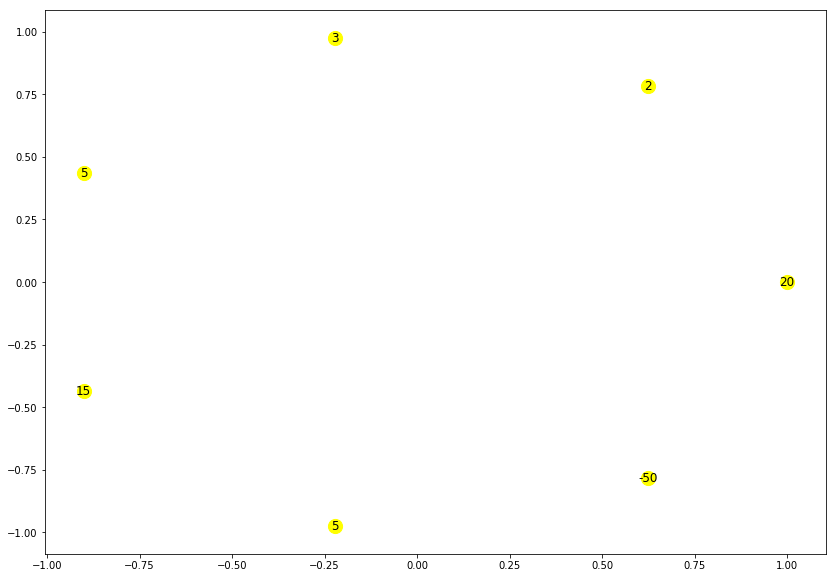

In [12]:
plt.show()
plot_graph(nodes, edges)

# Min-cost flow as a linear program

In [13]:
matrix_names

[['x00', 'x10', 'x20', 'x30', 'x40', 'x50', 'x60'],
 ['x01', 'x11', 'x21', 'x31', 'x41', 'x51', 'x61'],
 ['x02', 'x12', 'x22', 'x32', 'x42', 'x52', 'x62'],
 ['x03', 'x13', 'x23', 'x33', 'x43', 'x53', 'x63'],
 ['x04', 'x14', 'x24', 'x34', 'x44', 'x54', 'x64'],
 ['x05', 'x15', 'x25', 'x35', 'x45', 'x55', 'x65'],
 ['x06', 'x16', 'x26', 'x36', 'x46', 'x56', 'x66']]

In [14]:
solver = pywraplp.Solver('hello_program',
                         pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# define variables and capacities
infinity = solver.infinity()
X = [[solver.IntVar(0.0, matrix_capacities[i][j], 'x'+str(i)+str(j))
      for j in range(N+1)]
     for i in range(N+1)]

# define supplies
for i in range(N):
    solver.Add(sum([X[i][j] for j in range(N+1)])
             - sum([X[j][i] for j in range(N+1)])
            == nodes["supplies"][i])

In [15]:
# additional constraints
B1 = [solver.IntVar(0.0, 1.0, 'b'+str(i)+str(N))
      for i in range(N)]
B2 = [solver.IntVar(0.0, 1.0, 'b'+str(N)+str(i))
      for i in range(N)]

for i in range(N):
    solver.Add(X[i][N] <= 1000*B1[i])
    solver.Add(X[N][i] <= 1000*B2[i])

# num_nodes_init
for i in range(N):
    solver.Add(sum(B1) + sum(B2) <= 2)

In [16]:
# define objective
solver.Minimize(sum([sum([matrix_unit_costs[i][j] * X[i][j]
                          for j in range(N+1)])
                     for i in range(N+1)]))

# sum[matrix_unit_costs[i][j] * X[i][j] for j in range(num_nodes)]
print('Number of variables =', solver.NumVariables())
print('Number of constraints =', solver.NumConstraints())

Number of variables = 61
Number of constraints = 24


In [17]:
# print(solver.ExportModelAsLpFormat(False).replace('\\', '').replace(',_', ','), sep='\n')

In [18]:
status = solver.Solve()

In [19]:
if status != pywraplp.Solver.OPTIMAL:
    print('The problem does not have an optimal solution.')
    
print('Solution:')
print('Objective value =', solver.Objective().Value())
print('')
print('Advanced usage:')
print('Problem solved in %f milliseconds' % solver.wall_time())
print('Problem solved in %d iterations'   % solver.iterations())
print('Problem solved in %d branch-and-bound nodes' % solver.nodes())

Solution:
Objective value = 82.0

Advanced usage:
Problem solved in 228.000000 milliseconds
Problem solved in 854 iterations
Problem solved in 2 branch-and-bound nodes


In [20]:
matrix_flows = [[x.solution_value() for x in xxx] for xxx in X]
for i,row in enumerate(matrix_flows):
    for j,cell in enumerate(row):
        if matrix_flows[i][j] > 0:
            edges.at["x"+str(i)+str(j),"flows"] = matrix_flows[i][j]

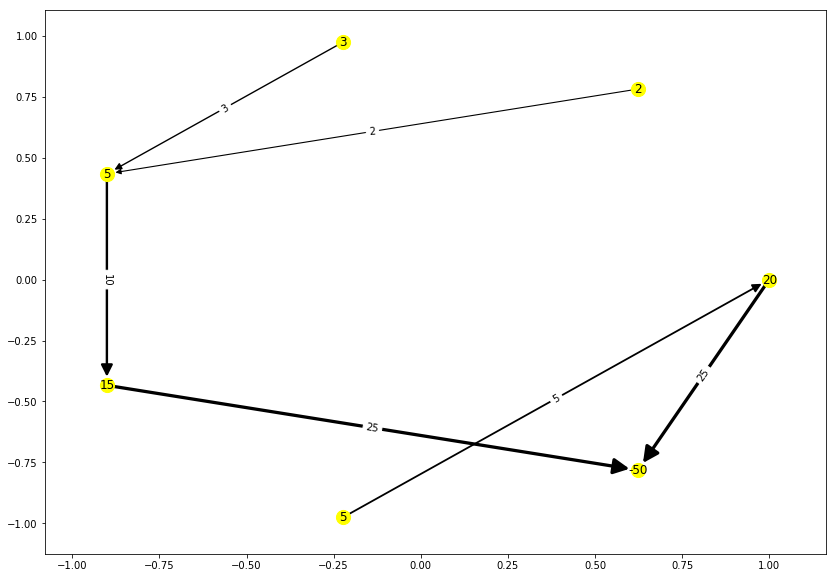

In [21]:
plot_graph(nodes, edges)

In [22]:
edges

,start_nodes,end_nodes,unit_costs,capacities,flows,names
names,,,,,,
x01,0,1,4,15,0,x01
x02,0,2,4,8,0,x02
x12,1,2,2,20,0,x12
x13,1,3,2,4,2,x13
x14,1,4,6,10,0,x14
x23,2,3,1,15,3,x23
x24,2,4,3,4,0,x24
x34,3,4,2,20,10,x34
x42,4,2,3,5,0,x42
